# Cadence Effects

In [1]:
import sys
sys.path.insert(0, '../')

from datetime import datetime

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import sncosmo
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from pytz import utc
from pwv_kpno.package_settings import ConfigBuilder, settings
from pwv_kpno import pwv_atm

from sn_analysis import filters
from sn_analysis import modeling
from sn_analysis import plasticc_data
from sn_analysis import sn_magnitudes

filters.register_lsst_filters(force=True)


../sn_analysis/plasticc_data.py:20: UserWarning: ``plasticc_sim_dir`` is not set in environment. Defaulting to /mnt/md0/snsims
  warn(f'``plasticc_sim_dir`` is not set in environment. Defaulting to {default_data_dir}')


In [2]:
plt.rcParams['figure.dpi'] = 100


## Atmospheric Variability


In [3]:
ctio_config = ConfigBuilder(
    site_name='cerro_tololo',
    primary_rec='CTIO',
    sup_rec=[]
)

ctio_config.save_to_ecsv('./cerro_tololo.ecsv', overwrite=True)
settings.import_site_config('./cerro_tololo.ecsv', overwrite=True)
settings.set_site('cerro_tololo')


In [4]:
pwv_atm.update_models(range(2012, 2019))


[2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [5]:
ctio_pwv = pwv_atm.measured_pwv().to_pandas('date')


(0.0, 25.0)

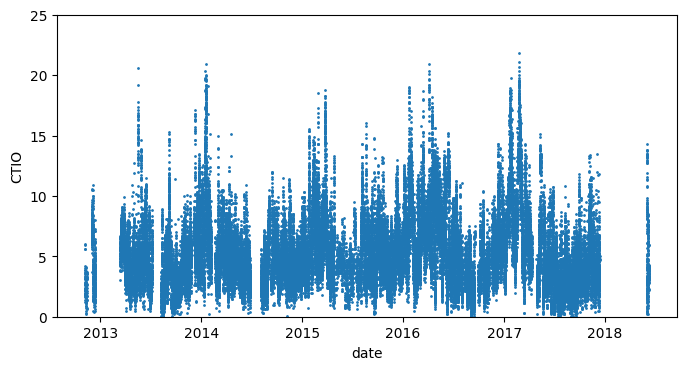

In [6]:
ctio_pwv.reset_index().plot.scatter(x='date', y='CTIO', s=1, figsize=(8, 4))
plt.ylim(0, 25)


In [7]:
good_pwv_data = ctio_pwv[ctio_pwv.CTIO <= 25]
good_pwv_data.index = good_pwv_data.index.map(lambda t: t.replace(year=2000))
folded_pwv = good_pwv_data.groupby(good_pwv_data.index).CTIO.median()


In [8]:
sampling_in_hour = 4
hour_in_day = 24
day_in_window = 7
window_size = sampling_in_hour * hour_in_day * day_in_window
rolling_mean_pwv = folded_pwv.rolling(window=window_size).mean()


In [9]:
# Todo, double check these dates.
mar_equinox = datetime(2000, 3, 20, tzinfo=utc)
jun_equinox = datetime(2000, 6, 21, tzinfo=utc)
sep_equinox = datetime(2000, 9, 22, tzinfo=utc)
dec_equinox = datetime(2000, 12, 21, tzinfo=utc)

winter_pwv = folded_pwv[(folded_pwv.index < mar_equinox) | (folded_pwv.index > dec_equinox)]
spring_pwv = folded_pwv[(folded_pwv.index > mar_equinox) & (folded_pwv.index < jun_equinox)]
summer_pwv = folded_pwv[(folded_pwv.index > jun_equinox) & (folded_pwv.index < sep_equinox)]
fall_pwv = folded_pwv[(folded_pwv.index > sep_equinox) & (folded_pwv.index < dec_equinox)]


winter_average = winter_pwv.mean()
spring_average = spring_pwv.mean()
summer_average = summer_pwv.mean()
fall_average = fall_pwv.mean()

winter_std = winter_pwv.std()
spring_std = spring_pwv.std()
summer_std = summer_pwv.std()
fall_std = fall_pwv.std()


In [10]:
print(f'Winter Average: {winter_average: .2f} +\- {winter_std : .2f} mm')
print(f'Spring Average: {spring_average: .2f} +\- {spring_std : .2f} mm')
print(f'Summer Average: {summer_average: .2f} +\- {summer_std : .2f} mm')
print(f'Fall Average  : {fall_average: .2f} +\- {fall_std : .2f} mm')


Winter Average:  6.87 +\-  1.85 mm
Spring Average:  5.07 +\-  1.36 mm
Summer Average:  3.69 +\-  1.21 mm
Fall Average  :  4.45 +\-  1.02 mm


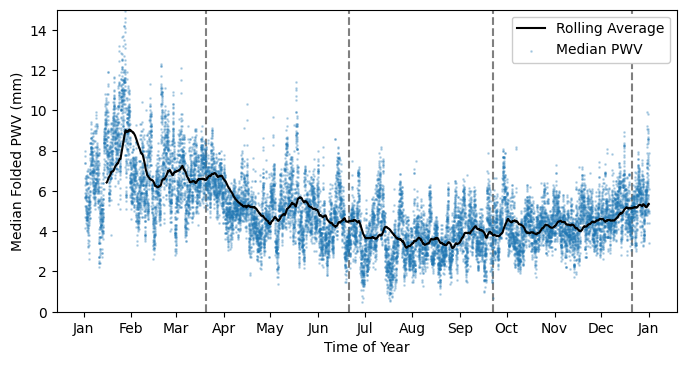

In [13]:
fig, axis = plt.subplots(figsize=(8, 4))
for equinox_date in (mar_equinox, jun_equinox, sep_equinox, dec_equinox):
    axis.axvline(equinox_date, linestyle='--', color='grey', zorder=0)

axis.scatter(folded_pwv.index, folded_pwv, s=1, alpha=.25, label='Median PWV')
axis.plot(folded_pwv.index, rolling_mean_pwv, color='k', label='Rolling Average')

plt.ylabel('Median Folded PWV (mm)')
plt.xlabel('Time of Year')
plt.ylim(0, 15)

locator = mdates.MonthLocator()
formatter = mdates.DateFormatter('%b')
axis.xaxis.set_major_locator(locator)
axis.xaxis.set_major_formatter(formatter)
axis.legend(framealpha=1)


## The PLaSTICC Data

Instead of evaluating different cadences from scratch, we rely on data from the PLaSTICC simulations.
First we check for any cadence simulations available on the notebook's host server.


In [14]:
plasticc_data.get_available_cadences()


['alt_sched_rolling',
 'rolling_mix_10yrs_opsim',
 'kraken_2026',
 'rolling_10yrs_opsim',
 'alt_sched',
 'nexus_2097']

Simulated light-curves are written in the SNANA file format and are distributed across multiple files. We load a light-curve from one of these files and demosntrate the data model below. Each cadence includes simulations run with multiple supernova models. In this notebook we only need simulations for normal SNe (Model 11). 


In [15]:
demo_cadence = 'alt_sched_rolling'
demo_cadence_header_files = plasticc_data.get_model_headers('alt_sched_rolling', 11)

demo_header_path = demo_cadence_header_files[0]
with fits.open(demo_header_path) as _temp:
    light_curves_per_file = len(_temp[1].data) 

print('Files per cadence:', len(demo_cadence_header_files))
print('Max light-curves per file:', light_curves_per_file)
    

Files per cadence: 40
Max light-curves per file: 81332


In [16]:
plasticc_lc = next(plasticc_data.iter_lc_for_header(demo_header_path, verbose=False))


In [17]:
plasticc_lc.meta


OrderedDict([('SUBSURVEY', '                                        '),
             ('SNID', '8153737         '),
             ('IAUC', 'NULL            '),
             ('FAKE', 2),
             ('RA', 253.055557),
             ('DECL', -60.056278),
             ('PIXSIZE', 0.20000000298023224),
             ('NXPIX', -9),
             ('NYPIX', -9),
             ('CCDNUM', 0),
             ('SNTYPE', 111),
             ('NOBS', 199),
             ('PTROBS_MIN', 1),
             ('PTROBS_MAX', 199),
             ('MWEBV', 0.15503360331058502),
             ('MWEBV_ERR', 0.007751679979264736),
             ('REDSHIFT_HELIO', 0.5014199614524841),
             ('REDSHIFT_HELIO_ERR', 0.23810000717639923),
             ('REDSHIFT_FINAL', 0.5016952753067017),
             ('REDSHIFT_FINAL_ERR', 0.23810000717639923),
             ('VPEC', 0.0),
             ('VPEC_ERR', 300.0),
             ('HOSTGAL_OBJID', 277268),
             ('HOSTGAL_PHOTOZ', 0.5014199614524841),
             ('HOSTGA

In [18]:
plasticc_lc


MJD,FLT,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,ZEROPT,SIM_MAGOBS
float64,str2,str12,int32,float32,float32,float32,float32,float32,float32,float32
60750.3891,z,NULL,0,0.0,-9.732752,18.38342,1.72,59.76,30.97,98.75439
60750.4025,Y,NULL,0,0.0,41.852177,45.757626,1.91,57.62,30.02,98.79263
60751.3921,z,NULL,0,0.0,19.945679,18.32146,1.75,57.91,30.96,98.75439
60751.4056,Y,NULL,0,0.0,-20.76702,38.440018,1.5,61.71,30.02,98.79263
60752.3933,z,NULL,0,0.0,15.96132,14.578538,1.4,58.11,30.97,98.75439
60752.407,Y,NULL,0,0.0,-5.417403,42.153595,1.6,64.03,30.03,98.79263
60753.3966,Y,NULL,0,0.0,-8.590908,19.21085,1.2,77.63,30.78,98.79263
60754.3856,r,NULL,0,0.0,-21.428425,9.080835,1.41,55.73,31.61,98.57609
60754.3973,z,NULL,0,0.0,-1.4168533,11.824018,1.23,53.75,30.97,98.75439


Here we reformat the data to be compatible with `sncosmo` only so we can easily visualize the light-curve.


In [19]:
def format_plasticc_sncosmo(data_table):
    lc = Table({
        'time': data_table['MJD'],
        'band': ['lsst_hardware_' + f.lower().strip() for f in data_table['FLT']],
        'flux': data_table['FLUXCAL'],
        'fluxerr': data_table['FLUXCALERR'],
        'zp': data_table['ZEROPT'],
        'photflag': data_table['PHOTFLAG']
    })
        
    lc['zpsys'] = 'AB'
    lc.meta = data_table.meta
    return lc
        

In [20]:
formatted_lc = format_plasticc_sncosmo(plasticc_lc)


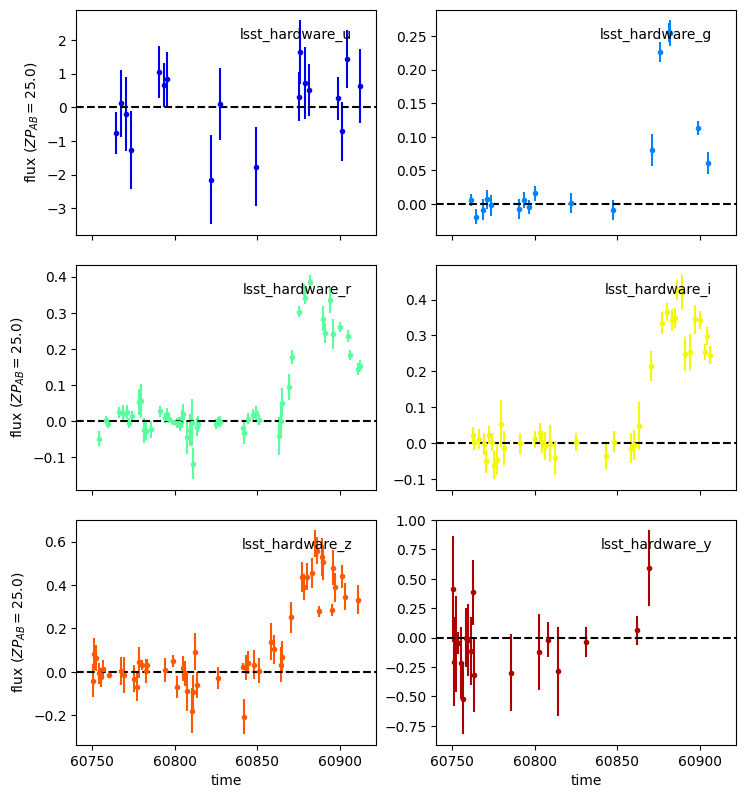

In [21]:
sncosmo.plot_lc(formatted_lc);


We note that many of the above data points are flagged as being non-detections (`photflag == 0`). Here are just the detections.

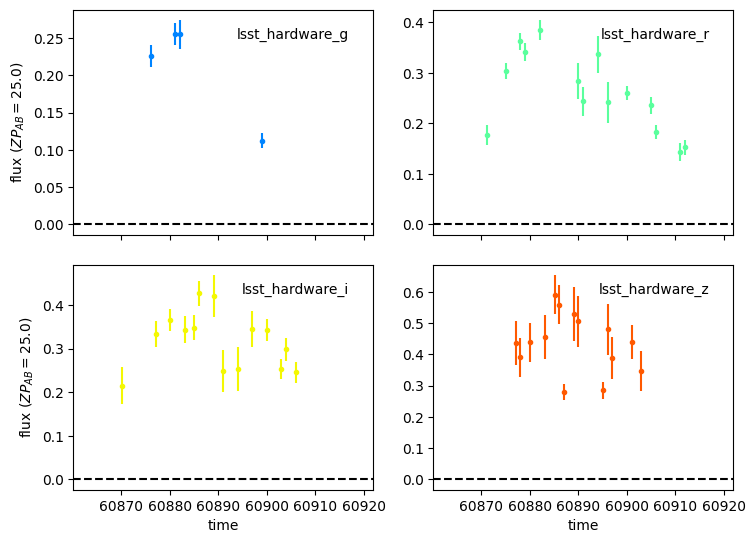

In [22]:
sncosmo.plot_lc(formatted_lc[formatted_lc['photflag'] != 0]);


## Simulating Light-Curves

Since we need to add in our own atmospheric variability, the pre-tabulated flux values above are of limited use. However, we can use the PLaSTICC light-curves to establish the cadence and model parameters for each simulated light-curve. This information can then be used to simulate our own light-curves with `sncosmo`.

Most of the data we need can be pulled directly from the light-curve or it's meta data. The one exception is the gain and skynoise, which need to be calculated:

$$ \sigma_f = \sqrt{\sigma_s ^ 2 + \frac{|f|}{gain}} $$
$$ \sigma_f^2 = \sigma_s^2 + \frac{|f|}{gain} $$
$$ \sigma_f^2 - \frac{|f|}{gain} = \sigma_s^2 $$
$$ \sqrt{\sigma_f^2 - \frac{|f|}{gain}} = \sigma_s $$


In [23]:
def iter_custom_lcs(cadence, verbose=True, drop_nondetection=False):
    
    cadence_header = plasticc_data.get_model_headers(cadence, model=11)[0]
    for plasticc_lc in plasticc_data.iter_lc_for_header(cadence_header, verbose=verbose):
        
        if drop_nondetection:
            plasticc_lc = plasticc_lc[plasticc_lc['PHOTFLAG'] != 0]
        
        observations = Table({
            'time': plasticc_lc['MJD'],
            'band': ['lsst_hardware_' + f.lower().strip() for f in plasticc_lc['FLT']],  
            'zp': plasticc_lc['ZEROPT']
        })
        
        observations['zpsys'] = 'ab'
        observations['gain'] = 10
        observations['skynoise'] = np.sqrt(plasticc_lc['FLUXCALERR'] ** 2 - np.abs(plasticc_lc['FLUXCAL']) / observations['gain'])

        params = [{
            't0': formatted_lc.meta['SIM_PEAKMJD'], 
            'x1': formatted_lc.meta['SIM_SALT2x1'],
            'c': formatted_lc.meta['SIM_SALT2c'], 
            'z': formatted_lc.meta['SIM_REDSHIFT_CMB'],
            # 'x0': formatted_lc.meta['SIM_SALT2x0'], 
            'x0': modeling.calc_x0_for_z(formatted_lc.meta['REDSHIFT_FINAL'], 'salt2')
        }]
            
        model = sncosmo.Model('Salt2')
        yield sncosmo.realize_lcs(observations, model, params)[0]


In [24]:
custom_lc = next(iter_custom_lcs('alt_sched_rolling', verbose=False))


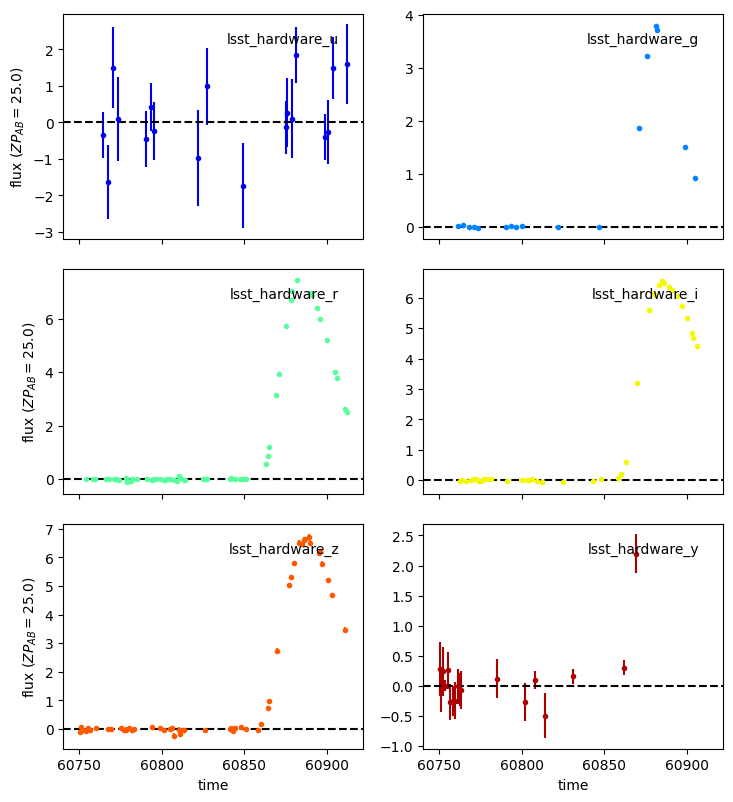

In [25]:
sncosmo.plot_lc(custom_lc);


In [26]:
custom_lc


time,band,flux,fluxerr,zp,zpsys
float64,str15,float64,float64,float32,str2
60750.3891,lsst_hardware_z,-29.522284679935293,18.356930288321372,30.97,ab
60750.4025,lsst_hardware_y,28.30107900136054,45.711869752172944,30.02,ab
60751.3921,lsst_hardware_z,15.274728275511583,18.26694736311453,30.96,ab
60751.4056,lsst_hardware_y,-6.062365318570944,38.41299660060954,30.02,ab
60752.3933,lsst_hardware_z,-7.869603894910815,14.523692220226069,30.97,ab
60752.407,lsst_hardware_y,24.865774741072606,42.14716831279726,30.03,ab
60753.3966,lsst_hardware_y,0.20862715282269909,19.188477581357485,30.78,ab
60754.3856,lsst_hardware_r,8.398207424566548,8.962071649804278,31.61,ab
60754.3973,lsst_hardware_z,-22.399525062637938,11.818024495439003,30.97,ab


## Fitting Light-Curves

In [ ]:
bands = ['lsst_hardware_' + b for b in 'ugrizy']

# Iterator over simulated light-curves
light_curves = iter_custom_lcs('alt_sched_rolling')

# Fit light curves
vparams = ['x0', 'x1', 'c']
fitted_mag, fitted_params = sn_magnitudes.fit_mag(
        'salt2', light_curves, vparams, bands=bands)
